# Compute the window moving fst within the X chrom

In [ ]:
#!pip install malariagen_data
#!pip install scikit-allel
#!pip install petl

### importing necessary package

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [3]:
import random
import functools
import petl as ptl
import itertools
import scipy
#from collections import Counter

In [4]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

In [5]:
#Mounting Google Drive
#import os
#from google.colab import drive
#drive.mount("drive")

# make dir 
#results_dir = "drive/MyDrive/Fru_paper"
#os.makedirs(results_dir, exist_ok=True)

Mounted at drive


Importing malariagen data set    
Let's select the the sample set from 

In [6]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")
#ag3
sets = ['AG1000G-AO', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CD', 
        'AG1000G-CF','AG1000G-CI', 'AG1000G-CM-A', 'AG1000G-CM-B', 'AG1000G-CM-C', 
        'AG1000G-FR', 'AG1000G-GA-A', 'AG1000G-GH', 'AG1000G-GM-A', 'AG1000G-GM-B', 
        'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-GW', 
        'AG1000G-KE', 'AG1000G-ML-A', 'AG1000G-ML-B', 'AG1000G-MW', 'AG1000G-MZ', 
        'AG1000G-TZ', 'AG1000G-UG'] 
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
#bf_samples.groupby(['location', 'aim_species']).size()

#To access to the genotypes within the X chromosome
chromX_gt = ag3.snp_calls(region="X", sample_sets=sets)

# Take some SNP in the X chromosome 
snps_pos = allel.SortedIndex(chromX_gt['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array 
filt = 'gamb_colu_arab' 
filt_val = chromX_gt[f"variant_filter_pass_{filt}"].values 
gt_filtered = allel.GenotypeDaskArray(chromX_gt["call_genotype"][filt_val].data)
filtered_pos = allel.SortedIndex(chromX_gt['variant_position'][filt_val].values)

/usr/local/lib/python3.7/dist-packages/malariagen_data/ag3.py:260: UserWarning: 
Your currently allocated Google Colab VM is not located in the US.
This usually means that data access will be substantially slower.
If possible, select "Runtime > Factory reset runtime" from the menu
to request a new VM and try again.

  """


Load sample metadata:   0%|          | 0/26 [00:00<?, ?it/s]

In [7]:
## define pop cohort 
#Create population column 
select_samples = df_samples.copy()
AO = ["Burkina Faso", "Ghana", "Cote d'Ivoire", "Guinea", "Mali", "Guinea-Bissau", "Gambia, The"]
AC = ["Angola", "Central African Republic", "Cameroon", "Democratic Republic of the Congo", "Gabon", ]
AE = ["Kenya", "Tanzania", "Malawi", "Uganda", "Mayotte", "Mozambique"]
af_region = []
for country in df_samples.country:
  if country in AO:
    af_region.append('WAF')
  elif country in AC:
    af_region.append('CAF')
  elif country in AE:
    af_region.append('EAF')
select_samples.insert(4, 'african_region', af_region)

pop_cohort = dict(
    [(f"{c} (An. {s} {sex})", list(df.index)) for (c, s, sex), df in df_samples.groupby(['country_iso', 'aim_species', 'sex_call'])]
     )
region_cohort = dict(
    [(f"{c} (An. {s})", list(df.index)) for (c, s), df in select_samples.groupby(['african_region', 'aim_species'])]
     )

sample_id, sel_pop = [], []
for key in region_cohort.keys():
    if len(region_cohort[key])>=30 and key.split('. ')[1][:3] != 'int':
        for i in region_cohort[key]:
            sample_id.append(i)
        sel_pop.append(key)

In [8]:
# compute allele counts
ac_sp = {}
with ProgressBar():
  for key in sel_pop:
    ac_sp[key] = gt_filtered.take(region_cohort[key], axis=1).count_alleles(max_allele=3).compute()

[########################################] | 100% Completed |  1min 24.5s
[########################################] | 100% Completed |  3min 21.4s
[########################################] | 100% Completed |  3min 11.4s
[########################################] | 100% Completed |  2min 45.6s
[########################################] | 100% Completed |  5min  7.0s
[########################################] | 100% Completed |  3min 28.1s


# Fst

In [9]:
@functools.lru_cache(maxsize=None)
def load_ac(pop):
    ac_spi = ac_sp[pop]
    return ac_spi
#load_ac(pop='arabiensis')

In [10]:
#@functools.lru_cache(maxsize=None)
def compute_windowed_pair_fst(pops, filt_pos, size):
    # order is irrelevant
    pop1, pop2 = pops
    ac_pop1 = load_ac(pop=pop1)
    ac_pop2 = load_ac(pop=pop2)
    loc_pass = ac_pop1.is_segregating() & ac_pop2.is_segregating() & (ac_pop1.max_allele() <= 1) & (ac_pop2.max_allele() <= 1)
    # Find selected SNPs pos
    pos=filt_pos[loc_pass]
    # compute windowed_fst
    fst_wind,windows,counts = allel.windowed_hudson_fst(pos, ac_pop1[loc_pass], ac_pop2[loc_pass],size=size)
    return fst_wind,windows,counts 
  
def compute_windowed_pairwise_fst(coh_list, pos_filt, size):
    pairwise_fst = {}
    wind_pairwise_fst = {}
    for pop1, pop2 in itertools.combinations(coh_list, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, wind, _ = compute_windowed_pair_fst(pops=pops,filt_pos=pos_filt,size=size)
        p1 = pop1.split(' ')[0]+'_'+pop1.split('(An. ')[1][:-1]
        p2 = pop2.split(' ')[0]+'_'+pop2.split('(An. ')[1][:-1]
        pairwise_fst[f'{p1}_{p2}'] = fst
        wind_pairwise_fst[f'wind_{p1}_{p2}'] = wind
    return pairwise_fst, wind_pairwise_fst

In [11]:
# compute fst and windows
fst_dict, wind_fst_dict = compute_windowed_pairwise_fst(coh_list=sel_pop, pos_filt=filtered_pos, size=50000) 

# warp fst data to dataframe
df_fst=pd.DataFrame(dict([(k, pd.Series(v)) for k, v in fst_dict.items()]))
df_fst.fillna(0, inplace=True)
df_fst[df_fst<0] = 0
df_wind=pd.DataFrame(np.mean(wind_fst_dict['wind_CAF_coluzzii_EAF_arabiensis'], axis=1), columns=['wind_mean'])
data_fst=pd.concat([df_wind, df_fst], axis=1)
print('done')

done


# Plotting the Fst

In [22]:
# Plotting FST
# Compute the figure of sequence divergence 
def fig_fst_pair(x, y, title=None,  ax=None, color=None, ylab=None, xlab=None, 
                 annot=None, fig_name=None):
  #define ax 
  if ax is None:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.despine(ax=ax, offset=5)

  # make plot 
  ax.plot(x, y, linestyle='-', marker=None, color=color, linewidth=0.4)
  # Plot title
  if title:
    ax.set_title(f'{title}')
  
  # Customize plot 
  if ylab:
    ax.set_ylabel('Pairwise  $F_{ST}$')
  if xlab:
    ax.set_xlabel('Chrom X (bp)')
  
  #annotations
  if annot:
    ax.axvspan(1283016, 1373662, color='magenta', alpha=0.1, lw=0.3)
    ax.annotate('$fru$ region', xy=(1373662, 0.3), xytext=(1800000, 0.3), color='darkred',
                arrowprops=dict(arrowstyle="->", color='crimson'))
  
  #ax setting 
  ax.set_ylim(0,1)
  xlim=(list(x)[0], list(x)[-1])
  ax.set_xlim(*xlim)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()]) 
  if fig_name:
    fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/2R_{fig_name}.png", dpi=300, bbox_inches='tight')

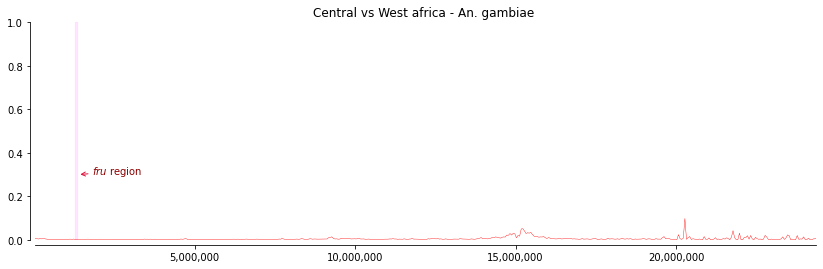

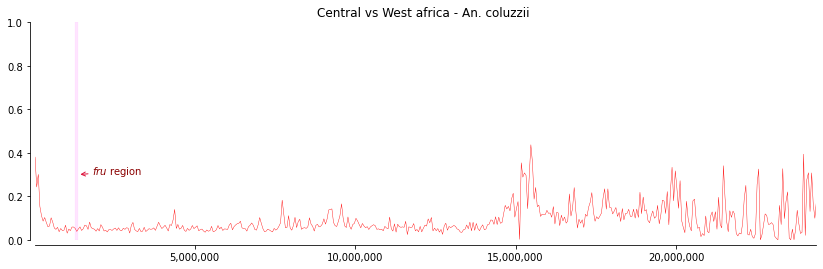

In [29]:
fig_fst_pair(x=data_fst.wind_mean, y=data_fst.CAF_gambiae_WAF_gambiae, title='Central vs West africa - An. gambiae ', 
             annot=True, color='red')
fig_fst_pair(x=data_fst.wind_mean, y=data_fst.CAF_coluzzii_WAF_coluzzii, title='Central vs West africa - An. coluzzii ', 
             annot=True, color='red')


In [16]:
#pop_colors
fst_colors, label_fst, key_list = {}, {}, list(fst_dict.keys())
colored = sns.color_palette("husl", len(key_list))
for i in range(len(key_list)):
    fst_colors[key_list[i]] = colored[i]
    label_fst[key_list[i]] = key_list[i]

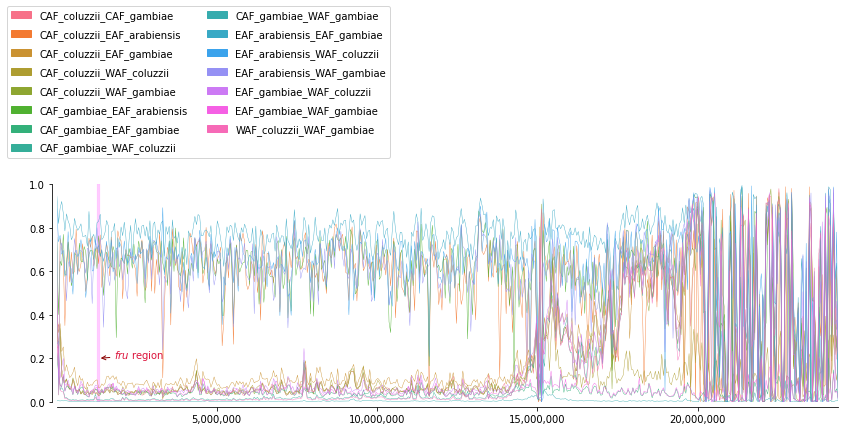

In [30]:
def plot_fst_a(data = data_fst, f_list=key_list, annot=None, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(14,4))
    sns.despine(ax=ax, offset=5)

  #Plot fst
  pos = data_fst[data_fst.columns[0]]
  for idx in f_list:
    fst = data_fst[idx]
    fig_fst_pair(x=pos, y=fst, ax=ax, color=fst_colors[idx])

  # add annotations 
  if annot:
    ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
    ax.annotate('$fru$ region', xy=(1373662, 0.2), xytext=(1800000, 0.2), color='crimson',
            arrowprops=dict(arrowstyle="->", color='darkred'))
  
  #legend
  handles = [mpl.patches.Patch(color=fst_colors[pop], label=label_fst[pop]) for pop in f_list]
  ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(-0.07, 1.1), ncol=2, labelspacing=0.8)

plot_fst_a(data = data_fst, f_list=key_list, annot=True, ax=None)

In [44]:
def plot_fst_all(data = data_fst, f_list=key_list, ylab=None, xlab=None, loc=[0.05, 0.3], ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(14,4))
    #sns.despine(ax=ax, offset=5)
  
  #Plot fst
  pos = data_fst[data_fst.columns[0]]
  for idx in f_list:
    fst = data_fst[idx]
    fig_fst_pair(x=pos, y=fst, ax=ax, ylab=ylab, xlab=xlab, color=fst_colors[idx])

  # add annotations 
  ax.axvspan(1283016, 1373662, color='maroon', alpha=0.2, lw=0.2)
  ax.annotate('$fru$ region', xy=(1373662, loc[0]), xytext=(2000000, loc[1]), color='crimson',
            arrowprops=dict(arrowstyle="->", color='darkred'))
  
  #legend
  handles = [mpl.patches.Patch(color=fst_colors[pop], label=label_fst[pop]) for pop in f_list]
  ax.legend(handles=handles, loc='upper left', ncol=1, labelspacing=0.8)


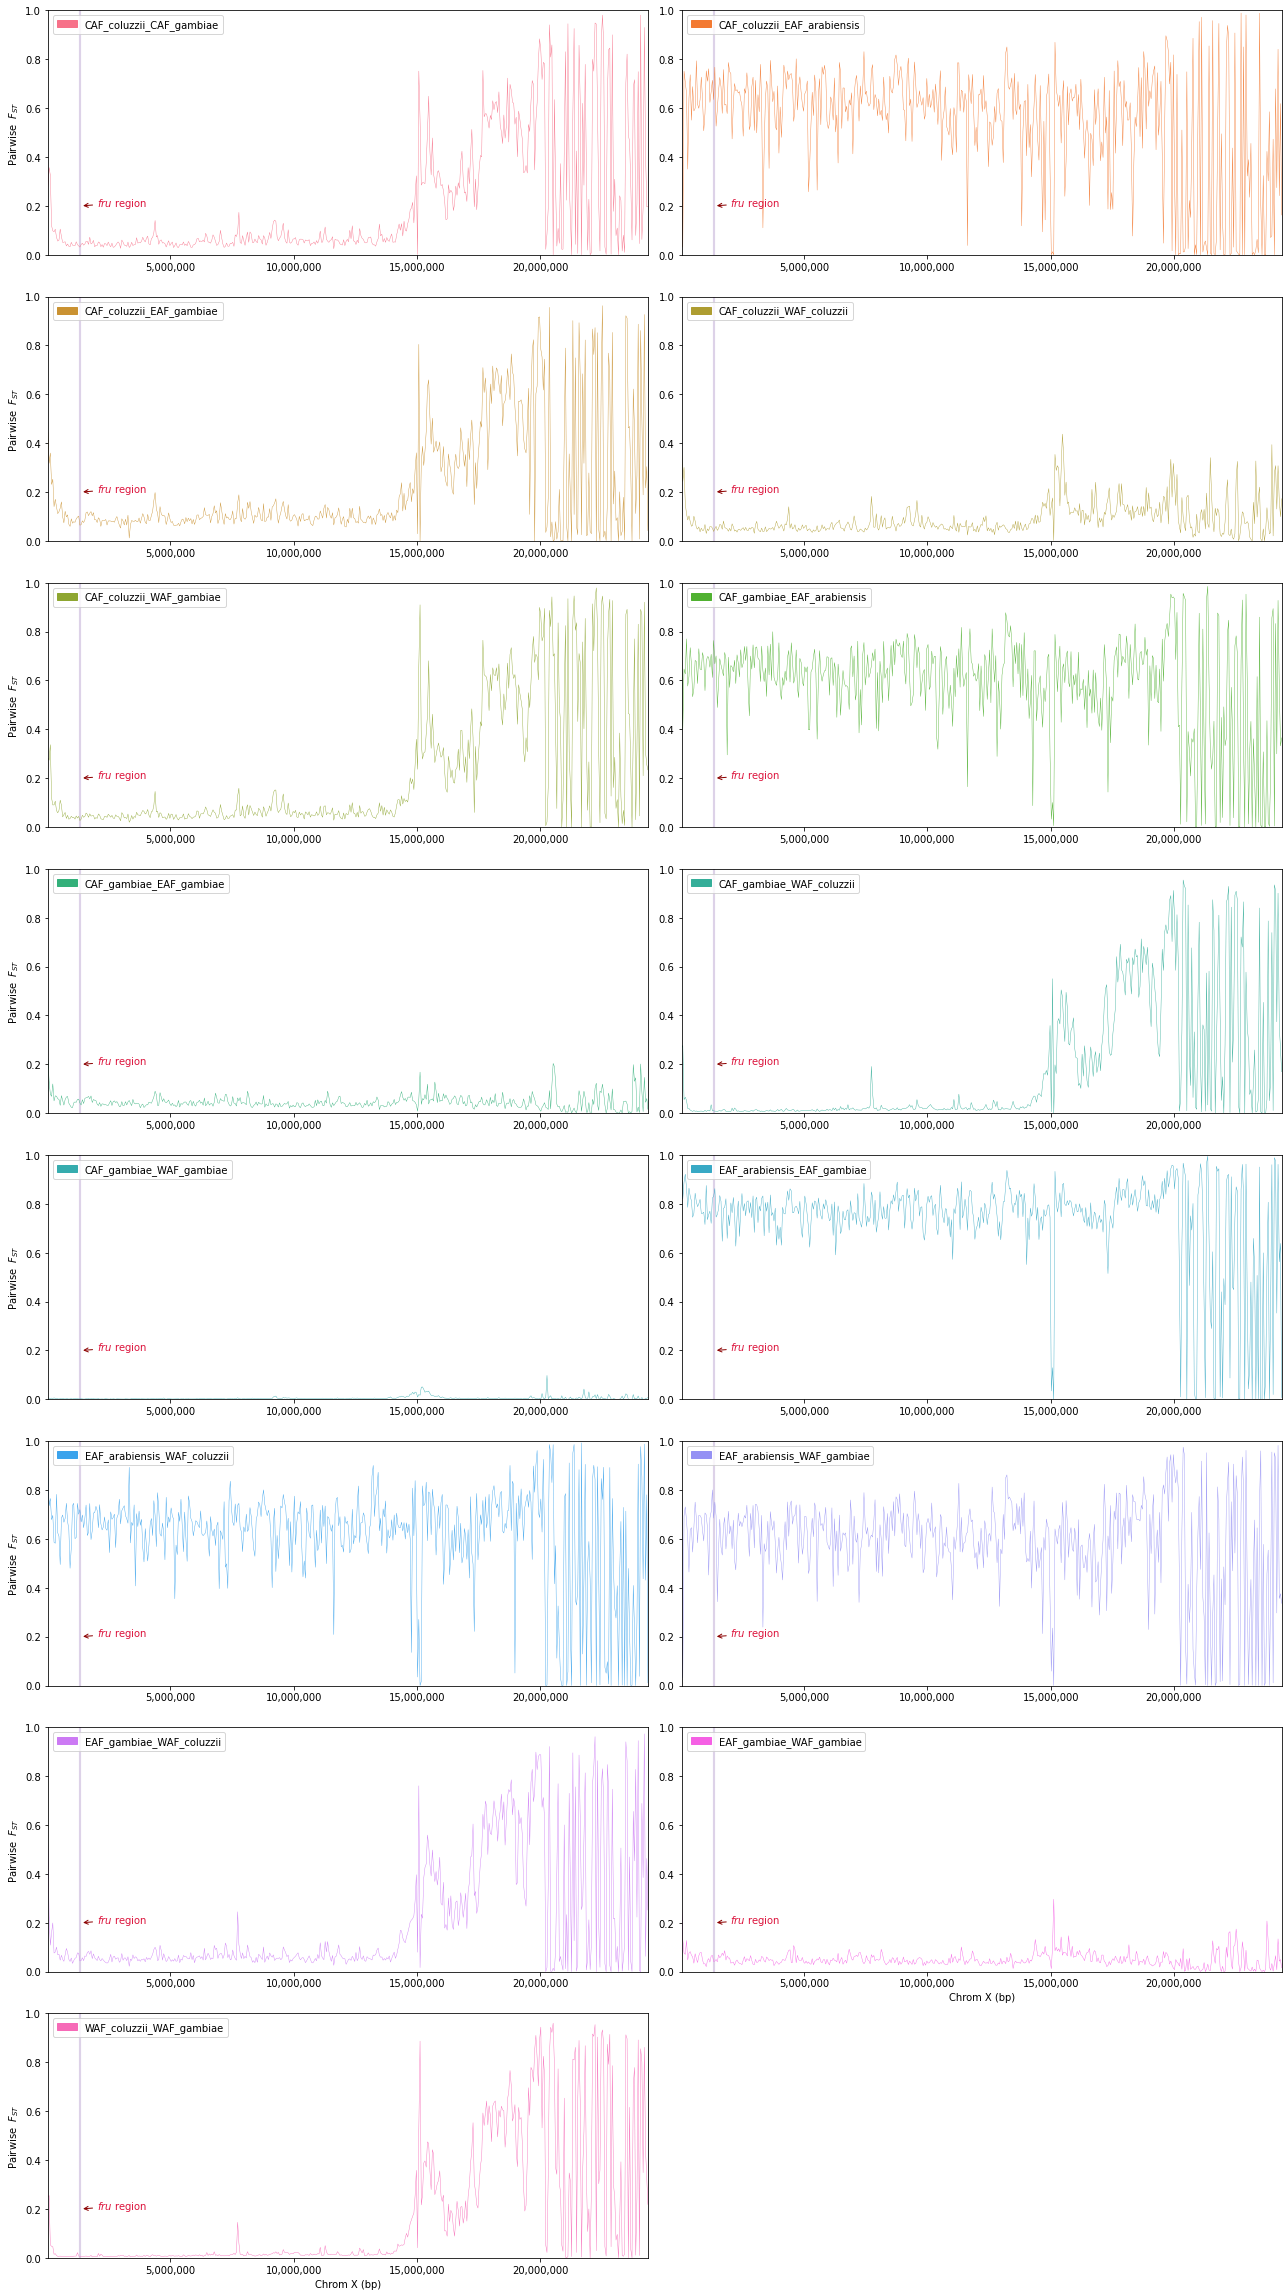

In [42]:
fig, ax = plt.subplots(figsize=(18,32))
gs = GridSpec(8, 2, figure=fig)

ax0 = plt.subplot(gs[0, 0])
fst_list = [key_list[0]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ylab=True, ax=ax0)

ax1 = plt.subplot(gs[0, 1])
fst_list = [key_list[1]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax1)

ax2 = plt.subplot(gs[1, 0])
fst_list = [key_list[2]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2], ax=ax2)

ax3 = plt.subplot(gs[1, 1])
fst_list = [key_list[3]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax3)

ax4 = plt.subplot(gs[2, 0])
fst_list = [key_list[4]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ylab=True, ax=ax4)

ax5 = plt.subplot(gs[2, 1])
fst_list = [key_list[5]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax5)

ax6 = plt.subplot(gs[3, 0])
fst_list = [key_list[6]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2], ax=ax6)

ax7 = plt.subplot(gs[3, 1])
fst_list = [key_list[7]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax7)

ax8 = plt.subplot(gs[4, 0])
fst_list = [key_list[8]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2], ax=ax8)

ax9 = plt.subplot(gs[4, 1])
fst_list = [key_list[9]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax9)

ax10 = plt.subplot(gs[5, 0])
fst_list = [key_list[10]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2], ax=ax10)

ax11 = plt.subplot(gs[5, 1])
fst_list = [key_list[11]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax11)

ax12 = plt.subplot(gs[6, 0])
fst_list = [key_list[12]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2], ax=ax12)

ax13 = plt.subplot(gs[6, 1])
fst_list = [key_list[13]]
plot_fst_all(data = data_fst, f_list=fst_list, xlab=True, loc=[0.2, 0.2], ax=ax13)

ax14 = plt.subplot(gs[7, 0])
fst_list = [key_list[14]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, xlab=True, loc=[0.2, 0.2], ax=ax14)

fig.tight_layout()
#fig.savefig("drive/MyDrive/Fru_paper/Fru_graph/pair_fst.png", dpi=300, bbox_inches='tight')

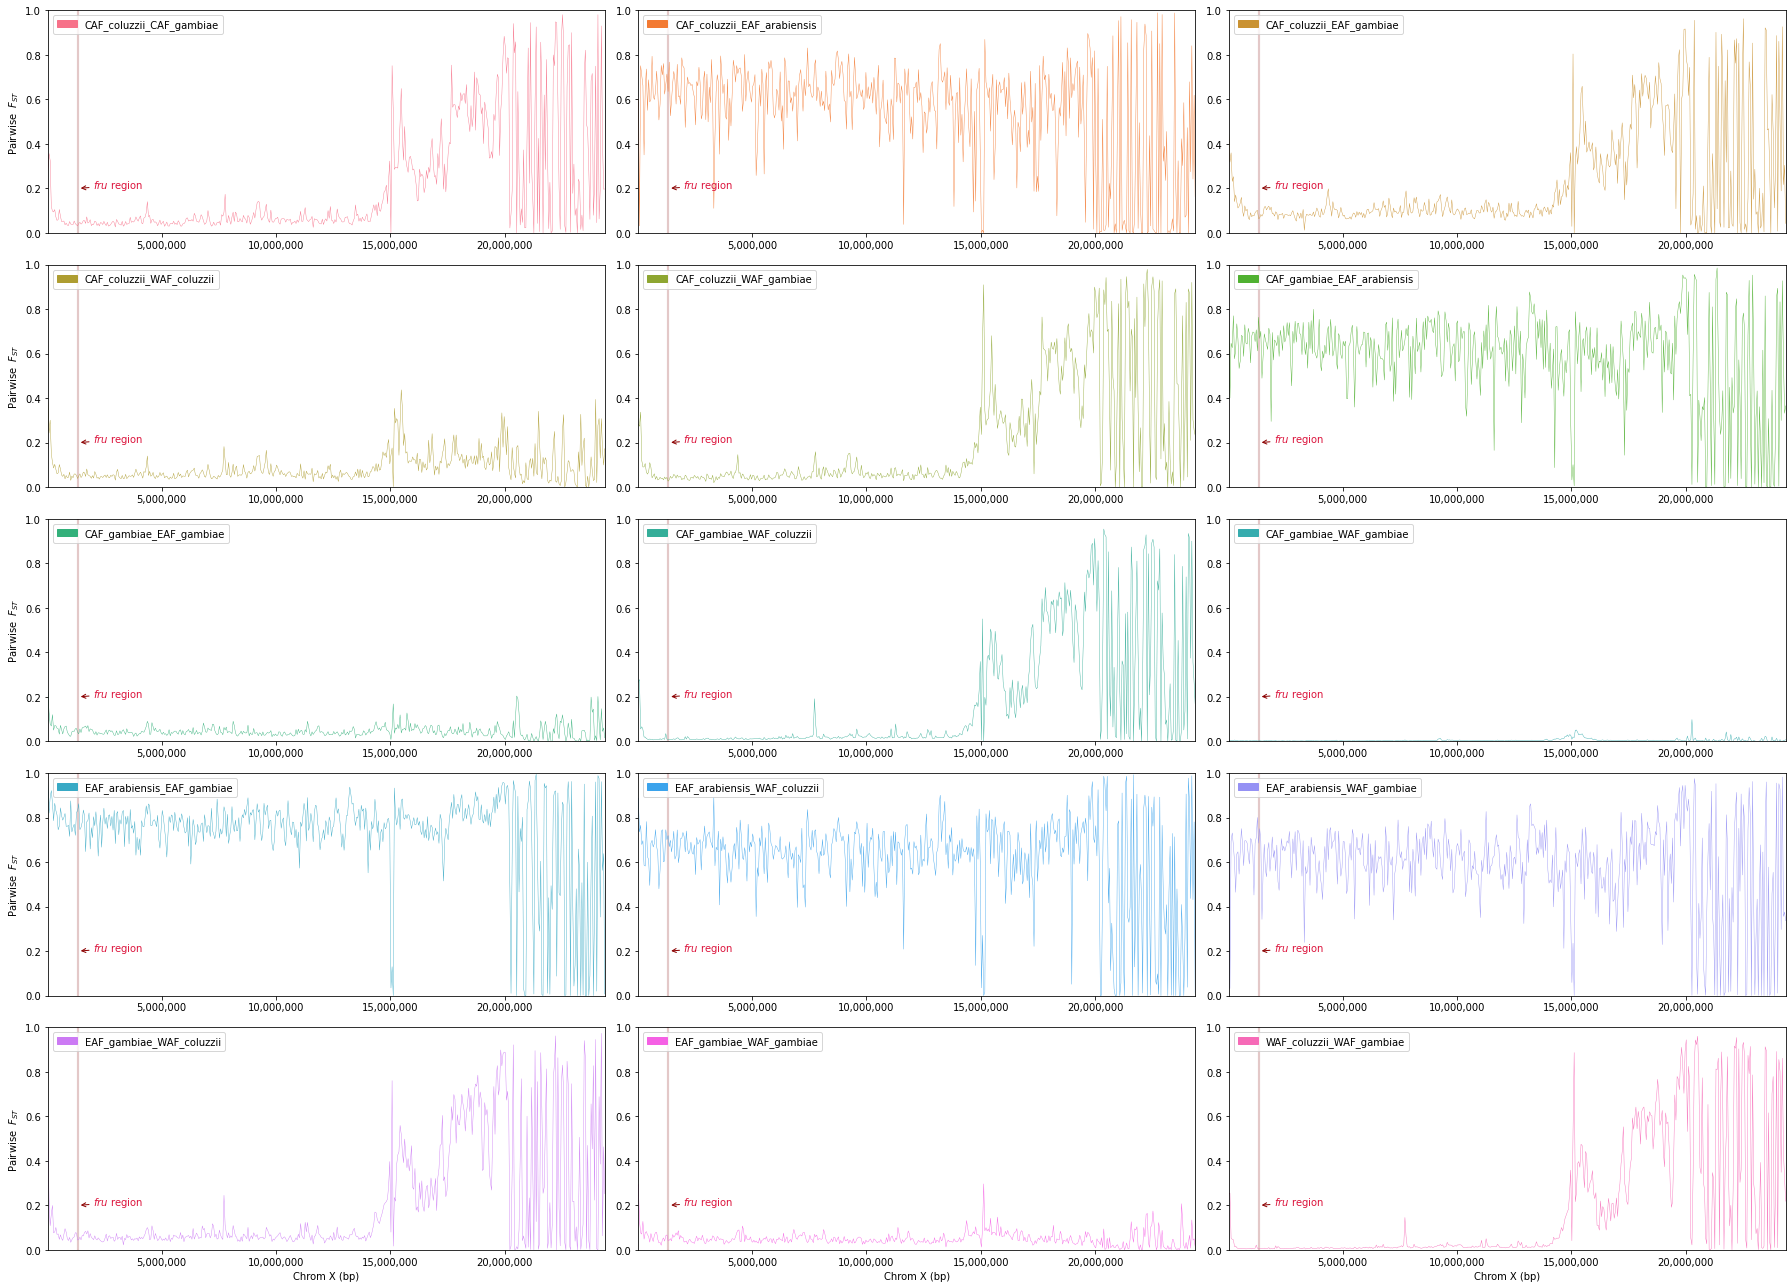

In [46]:
fig, ax = plt.subplots(figsize=(25,18))
gs = GridSpec(5, 3, figure=fig)

ax0 = plt.subplot(gs[0, 0])
fst_list = [key_list[0]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2],  ax=ax0)

ax1 = plt.subplot(gs[0, 1])
fst_list = [key_list[1]]
plot_fst_all(data = data_fst, f_list=fst_list,loc=[0.2, 0.2], ax=ax1)

ax2 = plt.subplot(gs[0, 2])
fst_list = [key_list[2]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2],  ax=ax2)

ax3 = plt.subplot(gs[1, 0])
fst_list = [key_list[3]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2], ax=ax3)

ax4 = plt.subplot(gs[1, 1])
fst_list = [key_list[4]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax4)

ax5 = plt.subplot(gs[1, 2])
fst_list = [key_list[5]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax5)

ax6 = plt.subplot(gs[2, 0])
fst_list = [key_list[6]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2],  ax=ax6)

ax7 = plt.subplot(gs[2, 1])
fst_list = [key_list[7]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2], ax=ax7)

ax8 = plt.subplot(gs[2, 2])
fst_list = [key_list[8]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2],  ax=ax8)

ax9 = plt.subplot(gs[3, 0])
fst_list = [key_list[9]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, loc=[0.2, 0.2],  ax=ax9)

ax10 = plt.subplot(gs[3, 1])
fst_list = [key_list[10]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2],  ax=ax10)

ax11 = plt.subplot(gs[3, 2])
fst_list = [key_list[11]]
plot_fst_all(data = data_fst, f_list=fst_list, loc=[0.2, 0.2],  ax=ax11)

ax12 = plt.subplot(gs[4, 0])
fst_list = [key_list[12]]
plot_fst_all(data = data_fst, f_list=fst_list, ylab=True, xlab=True, loc=[0.2, 0.2],  ax=ax12)

ax13 = plt.subplot(gs[4, 1])
fst_list = [key_list[13]]
plot_fst_all(data = data_fst, f_list=fst_list, xlab=True, loc=[0.2, 0.2],  ax=ax13)

ax14 = plt.subplot(gs[4, 2])
fst_list = [key_list[14]]
plot_fst_all(data = data_fst, f_list=fst_list, xlab=True, loc=[0.2, 0.2],  ax=ax14)

fig.tight_layout()
#fig.savefig("drive/MyDrive/Fru_paper/Fru_graph/pair_fst1.png", dpi=300, bbox_inches='tight')